# Reinforcement Learning

В этом задании постараемся разобраться в проблеме обучения с подкреплением, реализуем алгоритм REINFORCE и научим агента с помощью этого алгоритма играть в игру Cartpole.

Установим и импортируем необходимые библиотеки, а также вспомогательные функции для визуализации игры агента.

In [1]:
!pip install gym pandas torch matplotlib pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg x11-utils > /dev/null 2>&1

In [2]:
from IPython.display import clear_output, HTML
from IPython import display as ipythondisplay
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import numpy as np
import glob
import time
import io
import base64
import gym
from gym.wrappers import Monitor
import torch
import collections
import pandas as pd
from torch import nn
from torch.optim import Adam
from torch.distributions import Categorical

In [4]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [5]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #позволяет перенести тензор на GPU, если он доступен в системе

## OpenAI Gym

[OpenAI Gym](https://gym.openai.com) это набор сред для разработки и сравнения алгоритмов обучения с подкреплением.

OpenAI Gym предоставляет простой и универсальный API ко многим средам с разными свойствами, как простым так и сложным:
* Классические задачи управления и игрушечные примеры, которые можно найти в учебниках и на которых демонстрируется работа алгоритмов обучения с подкреплением (одна из этих сред используется в этом задании)
* Игры Atari (оказали огромное влияние на достижения в обучении с подкреплением в последние годы)
* 2D и 3D среды для контроля роботов в симуляции (используют проприетарный движок [Mojuco](http://www.mujoco.org))

Рассмотрим, как устроена среда [CartPole-v0](https://gym.openai.com/envs/CartPole-v0), с которой мы будем работать.

Для этого создадим среду и выведем ее описание.

In [7]:
env = gym.make("CartPole-v0")
print(env.env.__doc__)


    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along
        a frictionless track. The pendulum starts upright, and the goal is to
        prevent it from falling over by increasing and reducing the cart's
        velocity.

    Source:
        This environment corresponds to the version of the cart-pole problem
        described by Barto, Sutton, and Anderson

    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf

    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right

        Note: The amount the velocity that is reduced

Из этого описания мы можем узнать, как устроены пространства состояний и действий в этой среды, какие награды получаются на каждом шаге, а также, что нам необходимо сделать, чтобы научиться "решать" эту среду, а именно достич средней награды больше 195.0 или больше за 100 последовательных запусков агента в этой среде. Именно такого агента мы и попробуем создать и обучить.

Но для начала напишем вспомогательную функцию, которая будет принимать на вход среду, агента и число эпизодов, и возвращать среднюю награду за 100 эпизодов. С помощью этой функции мы сможем протестировать, насколько хорошо обучился наш агент, а также визуализировать его поведение в среде.

In [8]:
def test_agent(env, agent=None, n_episodes=100):
    """Runs agent for n_episodes in environment and calclates mean reward.
    
    Args:
        env: The environment for agent to play in
        agent: The agent to play with. Defaults to None - 
            in this case random agent is used.
        n_episodes: Number of episodes to play. Defaults to 100.

    Returns:
        Mean reward for 100 episodes.
    """
    total_reward = []
    for episode in range(n_episodes):
        episode_reward = 0
        observation = env.reset()
        t = 0
        while True:
            if agent:
                with torch.no_grad():
                    probs = agent(torch.FloatTensor(observation).to(device))
                    dist = Categorical(probs)
                    action = dist.sample().item()
            else:
                action = env.action_space.sample()
            observation, reward, done, info = env.step(action)
            episode_reward += reward
            t += 1
            if done:
                print("Episode {} finished after {} timesteps".format(episode+1, t+1))
                break
        total_reward.append(episode_reward)
        env.close()
                   
    return np.mean(total_reward)

Протестируем и визуализируем случайного агента (параметр ```agent=False```).

In [9]:
test_agent(env, agent=False, n_episodes=100)

Episode 1 finished after 36 timesteps
Episode 2 finished after 15 timesteps
Episode 3 finished after 13 timesteps
Episode 4 finished after 21 timesteps
Episode 5 finished after 11 timesteps
Episode 6 finished after 36 timesteps
Episode 7 finished after 42 timesteps
Episode 8 finished after 24 timesteps
Episode 9 finished after 12 timesteps
Episode 10 finished after 30 timesteps
Episode 11 finished after 15 timesteps
Episode 12 finished after 17 timesteps
Episode 13 finished after 24 timesteps
Episode 14 finished after 39 timesteps
Episode 15 finished after 11 timesteps
Episode 16 finished after 18 timesteps
Episode 17 finished after 15 timesteps
Episode 18 finished after 12 timesteps
Episode 19 finished after 16 timesteps
Episode 20 finished after 16 timesteps
Episode 21 finished after 27 timesteps
Episode 22 finished after 14 timesteps
Episode 23 finished after 46 timesteps
Episode 24 finished after 16 timesteps
Episode 25 finished after 22 timesteps
Episode 26 finished after 34 times

22.99

Как видно, наш случайный агент выступает не очень хорошо и в среднем может удержать шест всего около 20 шагов.

Напишем функцию для визуализации агента и посмотрим на случайного агента.

In [10]:
def agent_viz(env="CartPole-v0", agent=None):
    """Visualizes agent play in the given environment.
    
    Args:
        env: The environment for agent to play in. Defaults to CartPole-v0.
        agent: The agent to play with. Defaults to None - 
            in this case random agent is used.

    Returns:
        Nothing is returned. Visualization is created and can be showed
            with show_video() function.
    """
    env = wrap_env(gym.make(env))
    observation = env.reset()
    while True:
        env.render() 
        if agent:
            with torch.no_grad():
                probs = agent(torch.FloatTensor(observation).to(device))
                dist = Categorical(probs)
                action = dist.sample().item()
        else:
            action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            break
            
    env.close()

In [11]:
agent_viz()
show_video()

Попробуем применить обучение с подкреплением и алгоритм REINFORCE для того, чтобы в среднем за 100 эпиздов мы держали шест не менее 195 шагов.

## REINFORCE

Вспомним, что из себя представляет алгоритм REINFORCE (Sutton & Barto) <img src="//i.imgur.com/bnASTrY.png" width="700">

1. Инициализуем политику (в качестве политики мы будем использовать глубокую нейронную сеть).
2. "Играем" в среде эпизод, используя нашу политику, или несколько (мы будем использовать последний вариант) и собираем данные о состояниях, действиях и полученных наградах. 
3. Для каждого состояния в собранных эпизодах вычисляем сумму дисконтированных наград, полученных из этого состояния, а также логорифм правдоподобия предпринятого действия в этом состоянии для нашей политики.
4. Обновляем параметры нашей политики по формуле на схеме.

### Политика

Наша политика должна принимать на вход состояние среды, а на выходе выдавать распределение по действиям, которые мы можем осуществлять в среде.

**Задание:** Создать класс нейронной сети со следующей архитектурой ```Linear -> ReLU -> Linear -> Softmax```. Параметрами инициализации должны служить размерности пространства состояний, пространства действий и размер скрытого слоя.

In [12]:
class Policy(nn.Module):
    """Policy to be used by agent.

    Attributes:
        state_size: Dimention of the state space of the environment.
        act_size: Dimention of the action space of the environment.
        hidden_size: Dimention of the hidden state of the agent's policy.
    """
    def __init__(self, state_size, act_size, hidden_size):
        super().__init__()
        self.state_size = state_size
        self.act_size = act_size
        self.hidden_size = hidden_size
        self.linear_1 = nn.Linear(state_size, hidden_size)
        self.ReLu = nn.ReLU(inplace=True)
        self.linear_2 = nn.Linear(hidden_size, act_size)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, inputs):
        inputs = inputs.reshape((-1,self.state_size))
        out = self.linear_1(inputs)
        out = self.ReLu(out)
        out = self.linear_2(out)
        return self.softmax(out).view(-1)

### Оценка правдоподобия и расчет суммы дисконтированных наград

**Задание:** Напишем вспомогательная функцию, которая принимает на вход политику, батч траекторий и фактор дисконтирования, и должна вернуть следующие величины: 
* правдоподобие действия на каждом шаге на траектории посчитанные для всего батча;
* дисконтированные суммы наград (reward-to-go) из каждого состояния среды на траектории посчитанные для всего батча;

**Hint**: Представим батч траекторий как ```list```, в котром также хранится ```list``` для каждой траектории, в котором каждый шаг хранится, как ```namedtuple```:
```transition = collections.namedtuple("transition", ["state", "action", "reward"])```

In [13]:
def process_traj_batch(policy, batch, discount):
    """Computes log probabilities for each action 
        and rewards-to-go for each state in the batch of trajectories.
    
    Args:
        policy: Policy of the agent.
        batch (list of list of collections.namedtuple): Batch of trajectories.
        discount (float): Discount factor for rewards-to-go calculation.

    Returns:
        log_probs (list of torch.FloatTensor): List of log probabilities for
            each action in the batch of trajectories.
        returns (list of rewards-to-go): List of rewards-to-go for 
            each state in the batch of trajectories.
    """
    log_probs = []
    returns = []
    for traj in batch:
        rewards = [0]*len(traj)
        for i in range(len(traj)):           
            probs_step = policy.forward(traj[i].state)
            prob_action = probs_step[traj[i].action.item()]
            log_probs.append(torch.log(prob_action))
            for j in range(i, len(traj)):
                rewards[i] += traj[j].reward*discount**(j-i)
        returns.extend(rewards)
    return log_probs, returns

Ваша реализация функции должна проходить следующий тест.

In [14]:
def test_process_traj_batch(process_traj_batch):
    
    transition = collections.namedtuple("transition", ["state", "action", "reward"])
    
    class HelperPolicy(nn.Module):
        def __init__(self):
            super(HelperPolicy, self).__init__()
        
            self.act = nn.Sequential(
                nn.Linear(4, 2),
                nn.Softmax(dim=0),
            )
        
        def forward(self, x):
            return self.act(x)
        
    policy = HelperPolicy()
    
    for name, param in policy.named_parameters():
        if name == "act.0.weight":
            param.data = torch.tensor([[1.7492, -0.2471, 0.3310, 1.1494],
                                       [0.6171, -0.6026, 0.5025, -0.3196]])
        else:
            param.data = torch.tensor([0.0262, 0.1882])
            
    batch = [
        [
            transition(state=torch.tensor([ 0.0462, -0.0018,  0.0372,  0.0063]), action=torch.tensor(0), reward=1.0), 
            transition(state=torch.tensor([ 0.0462, -0.1975,  0.0373,  0.3105]), action=torch.tensor(1), reward=1.0), 
            transition(state=torch.tensor([ 0.0422, -0.0029,  0.0435,  0.0298]), action=torch.tensor(0), reward=1.0), 
            transition(state=torch.tensor([ 0.0422, -0.1986,  0.0441,  0.3359]), action=torch.tensor(0), reward=1.0), 
        ],
        [
            transition(state=torch.tensor([ 0.0382, -0.3943,  0.0508,  0.6421]), action=torch.tensor(1), reward=1.0), 
            transition(state=torch.tensor([ 0.0303, -0.2000,  0.0637,  0.3659]), action=torch.tensor(1), reward=1.0), 
            transition(state=torch.tensor([ 0.0263, -0.0058,  0.0710,  0.0939]), action=torch.tensor(1), reward=1.0), 
            transition(state=torch.tensor([ 0.0262,  0.1882,  0.0729, -0.1755]), action=torch.tensor(0), reward=1.0)
        ]
    ]
    
    log_probs, returns = process_traj_batch(policy, batch, 0.9)
    assert sum(log_probs).item() == -6.3940582275390625, "Log probabilities calculation is incorrect!!!"
    assert sum(returns) == 18.098, "Log probabilities calculation is incorrect!!!"
    print("Correct!")

In [15]:
test_process_traj_batch(process_traj_batch)

Correct!


### Вспомогательные функции и гиперпараметры

Функция для расчета скользящего среднего - ее мы будем использовать для визуализации наград по эпизодам.

In [16]:
moving_average = lambda x, **kw: pd.DataFrame({'x':np.asarray(x)}).x.ewm(**kw).mean().values

Определим также гиперпараметры.

In [17]:
STATE_SIZE  = env.observation_space.shape[0] # размерность пространства состояний среды
ACT_SIZE = env.action_space.n # размерность пространства действий среды
HIDDEN_SIZE = 256 # размер скрытого слоя для политики
NUM_EPISODES = 1000 # количество эпиздов, которые будут сыграны для обучения
DISCOUNT = 0.99 # фактор дисконтирования
TRAIN_EVERY = 20

Инициализуем политику и алгоритм оптимизации - мы будем использовать Adam c праметрами по умолчанию.

In [18]:
policy = Policy(STATE_SIZE, ACT_SIZE, HIDDEN_SIZE).to(device)
optimizer = Adam(policy.parameters())

In [19]:
transition = collections.namedtuple("transition", ["state", "action", "reward"])

### Основной цикл обучения

Теперь, когда мы опредлели вспомогательные функции, то нам следует написать основной цикл обучения агент.
В цикле должно происходить следующее:

1. Играем количество эпизодов, определенное в гиперпараметре ```NUM_EPISODES```.
2. В каждом эпизоде сохраняем информацию о шагах на траектории - состояние, действие и награду.
3. В конце каждого эпизода сохраняем вышеуказанную информацию о траектории. 
4. Периодически обучаемся на собранных эпизодах каждые ```TRAIN_EVERY``` эпизодов:  
    4.1. Считаем для собранного батча для каждого шага на трактории правдоподобие и сумму дисконтированных наград.  
    4.2. Обновляем параметры политики агента по формуле, приведенной на схеме.

**Задание:** Реализовать алгоритм обучения, описанный на схеме и в тексте выше. Шаблон кода алгоритма представлен ниже. При этом следует сохранять сумму ревордов для каждого эпизода в переменную ```returns_history```. Алгоритму потребуется около 1000 эпизодов игры, для того чтобы научиться играть в игру (если после 1000 эпизодов агент играет немного хуже, чем для победы в игре, попробуйте обучать его немного дольше или установите критерий останова - когда средняя награда за 100 последних эпизодов превышает значение в ```env.spec.reward_threshold``` )

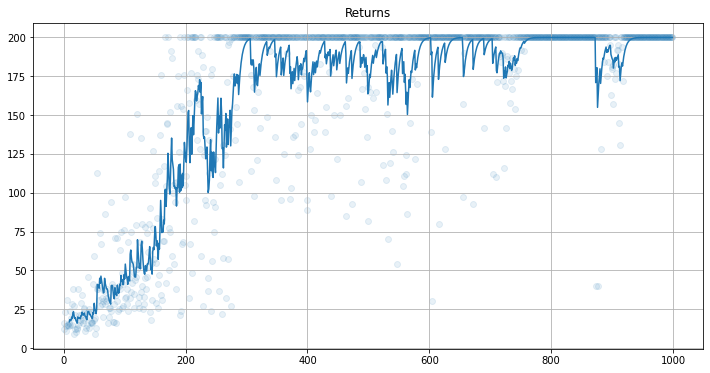

In [20]:
returns_history = []
traj_batch = []

for i in range(NUM_EPISODES):
        
    observation = env.reset()
    rewards = 0
    t = 0
    traj = []
    
    while True:
        with torch.no_grad():
            observation = torch.FloatTensor(observation).cuda()
            prev_observation = observation          
            probs = policy(observation)            
            dist = Categorical(probs)
            action = dist.sample().item()
            observation, reward, done, info = env.step(action)
            traj.append(transition(prev_observation, torch.tensor(action).cuda(), reward))
            rewards += reward
            t += 1
            if done:
                break

    env.close()
        
    returns_history.append(rewards)
            
    traj_batch.append(traj)
    
    if i % TRAIN_EVERY:
        log_probs, returns = process_traj_batch(policy, traj_batch, DISCOUNT)
        loss = -(torch.stack(log_probs) * torch.FloatTensor(returns).to(device)).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        traj_batch = []

    if i % 10:
        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.title('Returns'); plt.grid()
        plt.scatter(np.arange(len(returns_history)), returns_history, alpha=0.1)
        plt.plot(moving_average(returns_history, span=10, min_periods=10))
        plt.show()

Протестируем обученного агента.

In [21]:
test_agent(env, agent=policy, n_episodes=100)

Episode 1 finished after 201 timesteps
Episode 2 finished after 201 timesteps
Episode 3 finished after 201 timesteps
Episode 4 finished after 201 timesteps
Episode 5 finished after 201 timesteps
Episode 6 finished after 201 timesteps
Episode 7 finished after 201 timesteps
Episode 8 finished after 201 timesteps
Episode 9 finished after 201 timesteps
Episode 10 finished after 201 timesteps
Episode 11 finished after 201 timesteps
Episode 12 finished after 201 timesteps
Episode 13 finished after 201 timesteps
Episode 14 finished after 201 timesteps
Episode 15 finished after 201 timesteps
Episode 16 finished after 201 timesteps
Episode 17 finished after 201 timesteps
Episode 18 finished after 201 timesteps
Episode 19 finished after 201 timesteps
Episode 20 finished after 201 timesteps
Episode 21 finished after 201 timesteps
Episode 22 finished after 201 timesteps
Episode 23 finished after 201 timesteps
Episode 24 finished after 201 timesteps
Episode 25 finished after 201 timesteps
Episode 2

200.0

Обученный агент должен приближаться к искомому значению средней награды за 100 эпизодов 195.

Визуализируем обученного агента.

In [22]:
agent_viz(agent=policy)
show_video()

Как видно, агент выучил довольно хорошую стратегию для игры и способен долго удерживать шест.

### REINFORCE with baselines (Опционально)

В лекциях вы слышали, что при расчете градиентов для обновления параметров политики агента мы можем вычесть из суммы дисконтированных наград ```baseline``` для уменьшения дисперсии градиентов и ускорения сходимости обучения - такой алгоритм называется REINFORCE with baselines. В качестве ```baseline``` мы можем использовать другую нейронную сеть, которая будет оценивать сумму дисконтированных наград из данного состояния *V(s)*. 

Схема алгоритма REINFORCE with baselines (Sutton & Barto) <img src="//i.imgur.com/j3BcbHP.png" width="700">

**Задание**: Включите в уже разработанный алгоритм вторую нейронную сеть для оценки суммы дисконтированных наград *V(s)*. Используйте разницу между фактической суммой дисконтированных наград и оценкой в формуле функции потерь политики. В качестве функции потерь для *V(s)* используйте ```MSELoss```. Оцените скорость сходимости нового алгоритма.